In [176]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, confusion_matrix
import optuna
from optuna.samplers import TPESampler

from mypackage import dir

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Environment variables
modality = 'p'
project = 'japon'
data = dir.make_dir_line(modality, project) 
processed = data('processed')
models = data('models')
outputs = data('outputs')

iso_forest = IsolationForest(contamination=0.2, random_state=42)
smote = SMOTE(random_state=42)

# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

In [141]:
df = cargar_datos('dataset')
# Mujeres madres 
df = df.loc[df['id_secuencia_parentesco'] == '1-1']
# Eliminar atipicos
variables = ['satisfaccion_vida', 'satisfaccion_economica', 'satisfaccion_salud',
             'satisfaccion_seguridad', 'satisfaccion_trabajo',
             'satisfaccion_tiempo_libre','preocupacion', 'tristeza',
             'deseo_vivir', 'escalon_vida', 'felicidad']
df['anomaly'] = iso_forest.fit_predict(df.loc[:,variables])
df = df[df['anomaly'] == 1].drop(columns='anomaly')

df.head()

Loaded table: dataset


,id_familias,id_secuencia_parentesco,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,sexo,edad,parentesco,estado_civil,padre_vive,nivel_educativo_padre,madre_vive,nivel_educativo_madre,cultura_pueblo,campesino,satisfaccion_vida,satisfaccion_economica,satisfaccion_salud,satisfaccion_seguridad,satisfaccion_trabajo,satisfaccion_tiempo_libre,felicidad,preocupacion,tristeza,deseo_vivir,escalon_vida,atraccion_sexual,se_reconoce_como,num_cuartos,num_duermen,ingreso_hogar,cantidad_personas_hogar,P1_DEPARTAMENTO,P1_MUNICIPIO,REGION,CANT_HOGARES_VIVIENDA,CLASE,tipo_de_vivienda,energia,estrato,acueducto,alcantarillado,recoleccion_Basura,basura,aire,contaminacion_rios,invaciones
0,7910114-1,1-1,7910114,1,1,1,2,43,1,4.0,2,1.0,2,1.0,6,1.0,9.0,5.0,7.0,6.0,7.0,6.0,8.0,6.0,3.0,10.0,7.0,1.0,2.0,5.0,2.0,7.750000e+05,2.0,73.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0
2,7910121-1,1-1,7910121,1,1,1,2,45,1,4.0,2,1.0,2,1.0,6,1.0,6.0,6.0,7.0,4.0,6.0,5.0,5.0,5.0,5.0,6.0,5.0,1.0,2.0,3.0,2.0,1.892500e+06,2.0,18.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0
10,7910135-1,1-1,7910135,1,1,1,2,40,1,4.0,2,1.0,2,1.0,6,2.0,7.0,3.0,6.0,5.0,7.0,6.0,7.0,4.0,3.0,7.0,6.0,1.0,2.0,2.0,2.0,2.295833e+06,2.0,18.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0
21,7910170-1,1-1,7910170,1,1,1,2,42,1,5.0,2,6.0,1,NaN,6,1.0,10.0,9.0,10.0,8.0,9.0,10.0,9.0,1.0,0.0,10.0,8.0,1.0,2.0,3.0,2.0,7.850000e+05,3.0,18.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
24,7910187-1,1-1,7910187,1,1,1,2,46,1,4.0,2,4.0,2,4.0,6,2.0,5.0,4.0,4.0,5.0,7.0,7.0,5.0,6.0,7.0,5.0,6.0,1.0,2.0,3.0,2.0,9.000000e+05,4.0,13.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0


In [142]:
# df1 = df[df['padre_vive'] == 1]
# df1['feliz'] = np.where(df1['felicidad'] >= 8, 1, 0)
# df1['feliz'] = df1['feliz'].astype(str)
# fig = px.histogram(df1, x='ingreso_hogar', color='feliz', barmode='group')
# fig.show()

In [145]:
variables_modelos = ['felicidad', 
                     'campesino','P1_DEPARTAMENTO', 'se_reconoce_como', 'atraccion_sexual', 
                     'num_cuartos', 'cantidad_personas_hogar',
                     'edad', 'ingreso_hogar',
                     'satisfaccion_vida', 'satisfaccion_economica', 'satisfaccion_salud',
                     'satisfaccion_seguridad', 'satisfaccion_trabajo',
                     'satisfaccion_tiempo_libre', 'preocupacion', 'tristeza',
                     'deseo_vivir', 'escalon_vida']
df = df.loc[:,variables_modelos]

df = df.dropna(subset=['felicidad'])
df['felicidad'] = df['felicidad'].astype(int).astype(str)

cols_to_convert = ['campesino', 'P1_DEPARTAMENTO', 'se_reconoce_como', 'atraccion_sexual']
df[cols_to_convert] = df[cols_to_convert].astype(float).astype(int).astype(str)

# Conversión directa a int para las columnas especificadas
cols_to_convert = ['num_cuartos', 'cantidad_personas_hogar',
                   'satisfaccion_vida', 'satisfaccion_economica', 'satisfaccion_salud', 
                   'satisfaccion_seguridad', 'satisfaccion_trabajo', 'satisfaccion_tiempo_libre',
                   'preocupacion', 'tristeza', 'deseo_vivir', 'escalon_vida']

df[cols_to_convert] = df[cols_to_convert].astype(int)

df.head()

,felicidad,campesino,P1_DEPARTAMENTO,se_reconoce_como,atraccion_sexual,num_cuartos,cantidad_personas_hogar,edad,ingreso_hogar,satisfaccion_vida,satisfaccion_economica,satisfaccion_salud,satisfaccion_seguridad,satisfaccion_trabajo,satisfaccion_tiempo_libre,preocupacion,tristeza,deseo_vivir,escalon_vida
0,8,1,73,2,1,5,2,43,7.750000e+05,9,5,7,6,7,6,6,3,10,7
2,5,1,18,2,1,3,2,45,1.892500e+06,6,6,7,4,6,5,5,5,6,5
10,7,2,18,2,1,2,2,40,2.295833e+06,7,3,6,5,7,6,4,3,7,6
21,9,1,18,2,1,3,3,42,7.850000e+05,10,9,10,8,9,10,1,0,10,8
24,5,2,13,2,1,3,4,46,9.000000e+05,5,4,4,5,7,7,6,7,5,6


In [148]:
# Dividir datos
X = df.drop('felicidad', axis=1)
y = df['felicidad']

X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [149]:
# Identificar columnas
numeric_features = ['edad', 'ingreso_hogar',
                    'satisfaccion_vida', 'satisfaccion_economica', 'satisfaccion_salud',
                    'satisfaccion_seguridad', 'satisfaccion_trabajo',
                    'satisfaccion_tiempo_libre', 'preocupacion', 'tristeza',
                    'deseo_vivir', 'escalon_vida',
                    'num_cuartos', 'cantidad_personas_hogar']
categorical_features = ['campesino', 'P1_DEPARTAMENTO', 'se_reconoce_como', 'atraccion_sexual']

# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ("minmax", MinMaxScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

In [150]:
# Entrenar modelo
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['edad', 'ingreso_hogar',
                                                   'satisfaccion_vida',
                                                   'satisfaccion_economica',
                                                   'satisfaccion_salud',
                                                   'satisfaccion_seguridad',
                                                   'satisfaccion_trabajo',
                                                   'satisfaccion_tiempo_libre',
                                                   'preocupacion', 'tristeza',
                                                   'deseo_vivir',
                                                   'escalon_vida',
                                                   'num_cuartos',
                                                   'cantidad_personas_hogar']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['campesino',
                                                   'P1_DEPARTAMENTO',
                                                   'se_reconoce_como',
                                                   'atraccion_sexual'])])),
                ('classifier', SVC())])

In [151]:
y_pred = clf.predict(X_test)

In [152]:
recall_score(y_test, y_pred, average='weighted')

0.47714514835605454

In [153]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.70      0.63      0.66       139
           2       0.49      0.92      0.64       126
           3       0.45      0.87      0.59       153
           4       0.56      0.27      0.37       143
           5       0.48      0.18      0.26       143
           6       0.35      0.12      0.18       132
           7       0.40      0.35      0.37       140
           8       0.41      0.56      0.47       138
           9       0.48      0.38      0.42       133

    accuracy                           0.48      1247
   macro avg       0.48      0.48      0.44      1247
weighted avg       0.48      0.48      0.44      1247



In [154]:
new_data = {'edad': [58], 'ingreso_hogar': [2501667],
            'satisfaccion_vida': [6], 'satisfaccion_economica': [3], 'satisfaccion_salud': [6],
            'satisfaccion_seguridad': [3], 'satisfaccion_trabajo': [4],
            'satisfaccion_tiempo_libre': [7], 'preocupacion': [3], 'tristeza': [3],
            'deseo_vivir': [7], 'escalon_vida': [7],
            'num_cuartos': [3], 'cantidad_personas_hogar': [3],
            'campesino': [2], 'P1_DEPARTAMENTO': [18], 'se_reconoce_como': [2], 'atraccion_sexual': [1]
            }
new_data = pd.DataFrame(new_data)

new_data['campesino'] = new_data['campesino'].astype(str)
new_data['P1_DEPARTAMENTO'] = new_data['P1_DEPARTAMENTO'].astype(str)
new_data['se_reconoce_como'] = new_data['se_reconoce_como'].astype(str)
new_data['atraccion_sexual'] = new_data['atraccion_sexual'].astype(str)

new_data

,edad,ingreso_hogar,satisfaccion_vida,satisfaccion_economica,satisfaccion_salud,satisfaccion_seguridad,satisfaccion_trabajo,satisfaccion_tiempo_libre,preocupacion,tristeza,deseo_vivir,escalon_vida,num_cuartos,cantidad_personas_hogar,campesino,P1_DEPARTAMENTO,se_reconoce_como,atraccion_sexual
0,58,2501667,6,3,6,3,4,7,3,3,7,7,3,3,2,18,2,1


In [155]:
y_pred = clf.predict(new_data)
y_pred

array(['4'], dtype=object)

# Optimizacion

In [173]:
# Estandarización
scaler = MinMaxScaler()
scaler2 = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])
X_scaled = scaler2.fit_transform(X_scaled)

# Codificación One-hot
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(df[categorical_features])


# Guardar los transformadores
with open(models/'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open(models/'scaler2.pkl', 'wb') as file:
    pickle.dump(scaler2, file)

with open(models/'encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)


# Combinar datos
X = np.hstack([X_categorical.toarray(), X_scaled])
y = df['felicidad']

X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# Función objetivo para Optuna
def objective(trial):
    C = trial.suggest_float('C', 0.1, 10)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_float('gamma', 0.001, 10, log=True)

    model = SVC(C=C, kernel=kernel, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = recall_score(y_test, y_pred, average='weighted')

    return score

In [19]:
# Crear el estudio
study_name = "felicidad"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name,
                            direction='maximize',
                            storage=storage_name,
                            pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                            sampler=TPESampler())
study.optimize(objective, n_trials=10)

[I 2024-12-30 21:16:59,781] A new study created in RDB with name: felicidad
[I 2024-12-30 21:17:43,159] Trial 0 finished with value: 0.7136363636363636 and parameters: {'C': 5.812680865693123, 'kernel': 'rbf', 'gamma': 1.9181533777421338}. Best is trial 0 with value: 0.7136363636363636.
[I 2024-12-30 21:18:06,412] Trial 1 finished with value: 0.5644385026737968 and parameters: {'C': 3.4340269608907223, 'kernel': 'linear', 'gamma': 0.006227070526639943}. Best is trial 0 with value: 0.7136363636363636.
[I 2024-12-30 21:18:59,013] Trial 2 finished with value: 0.567379679144385 and parameters: {'C': 9.876296911197345, 'kernel': 'linear', 'gamma': 1.7775954217458816}. Best is trial 0 with value: 0.7136363636363636.
[I 2024-12-30 21:19:11,773] Trial 3 finished with value: 0.7751336898395722 and parameters: {'C': 5.873781715433735, 'kernel': 'poly', 'gamma': 0.07453770900946141}. Best is trial 3 with value: 0.7751336898395722.
[I 2024-12-30 21:19:22,662] Trial 4 finished with value: 0.7866310

In [21]:
df_study = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_study = df_study.sort_values(by=['value'], ascending=False)
df_study.to_csv(f'{study_name}.csv', encoding = 'utf-8-sig', index = False)
df_study.head(10)

,number,value,params_C,params_gamma,params_kernel,state
4,4,0.786631,4.284239,0.732132,poly,COMPLETE
8,8,0.786631,5.795161,8.105223,poly,COMPLETE
3,3,0.775134,5.873782,0.074538,poly,COMPLETE
0,0,0.713636,5.812681,1.918153,rbf,COMPLETE
7,7,0.633690,4.850378,0.009229,rbf,COMPLETE
2,2,0.567380,9.876297,1.777595,linear,COMPLETE
1,1,0.564439,3.434027,0.006227,linear,COMPLETE
9,9,0.559626,0.852682,0.472593,linear,COMPLETE
6,6,0.545455,0.269316,0.067649,linear,COMPLETE
5,5,0.352674,9.737275,0.006546,poly,COMPLETE


In [158]:
# Obtener los mejores hiperparámetros
best_params = study.best_params
best_params

{'C': 4.284238575708257, 'kernel': 'poly', 'gamma': 0.7321316694876744}

In [159]:
clf = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])

In [174]:
# Guardar el modelo
with open(models/'clf.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [160]:
# Entrenar modelo
clf.fit(X_train, y_train)

SVC(C=4.284238575708257, gamma=0.7321316694876744, kernel='poly')

In [177]:
y_pred = clf.predict(X_test)

In [162]:
score = recall_score(y_test, y_pred, average='weighted')
score

0.7866310160427807

In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          10       0.79      0.79      0.79       422
           2       0.98      1.00      0.99       426
           3       0.97      1.00      0.98       417
           4       0.93      1.00      0.96       415
           5       0.83      0.93      0.88       413
           6       0.72      0.80      0.76       411
           7       0.49      0.46      0.47       393
           8       0.50      0.35      0.41       428
           9       0.73      0.74      0.74       415

    accuracy                           0.79      3740
   macro avg       0.77      0.79      0.78      3740
weighted avg       0.77      0.79      0.78      3740



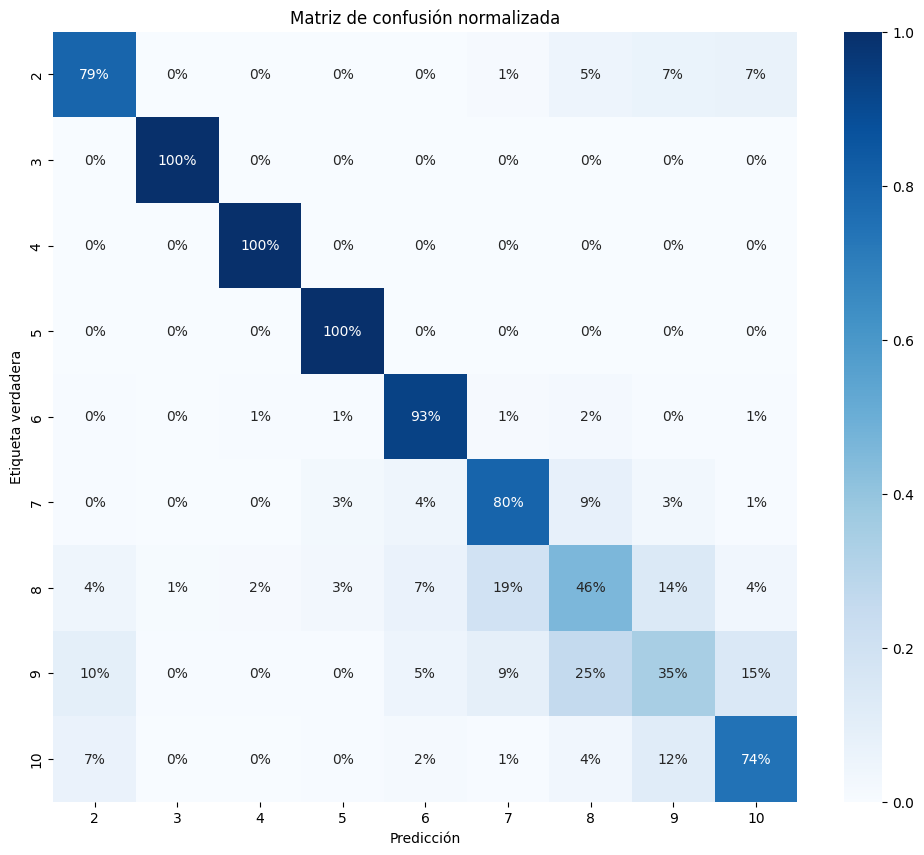

In [180]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ['2', '3', '4', '5', '6', '7', '8', '9', '10']

fig, axs = plt.subplots(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

In [166]:
# Estandarización
X_scaled = scaler.transform(new_data[numeric_features])
X_scaled = scaler2.transform(X_scaled)

# Codificación One-hot
X_categorical = encoder.transform(new_data[categorical_features])

# Combinar datos
X = np.hstack([X_categorical.toarray(), X_scaled])

In [167]:
y_pred = clf.predict(X)
y_pred

array(['7'], dtype=object)

In [27]:
print('Ok_')

Ok_
